# Objective
### The aim of this notebook is to generate the basis for the experimentally evaluated T1,T2 pair of values

In [11]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utils

import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg
import cfl #useful in data storage and reading, dont need it right now
import time

from tqdm import tqdm

ModuleNotFoundError: No module named 't1t2shuffle'

In [5]:
def nrmse(x1, x2):
    return np.linalg.norm(x1.ravel() - x2.ravel()) / np.linalg.norm(x1.ravel())

In [6]:
T2_values = np.load('subject2/Subject2_T2_vals_experimental.npy')#loading the experimental evaluated T2 values
T1_values = np.load('subject2/Subject2_T1_vals_experimental.npy')
mask = np.load('subject2/Subject2_mask_experimental.npy')
T1T2_vals = np.zeros((2,len(T1_values)))

T1T2_vals[0,:] = T1_values 
T1T2_vals[1,:] = T2_values
print(T1T2_vals.shape)

(2, 35818)


In [8]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg

def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    TR_vals = np.array([860, 1830, 2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    #update the code for stopping the driven equil case
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

ModuleNotFoundError: No module named 'epg.epgcpmg'; 'epg' is not a package

In [6]:
par_jobs = 32
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, T1T2_vals.T), total=len(T1T2_vals), leave=True)))

35818it [00:05, 6758.84it/s]         


In [7]:
X_sim3 = np.array(result_dict).T
print(X_sim3.shape)

(48, 35818)


In [8]:
#finding the basis vector by using the SVD decomposition, the u matrix contains the basis vectors
u, s, vh = np.linalg.svd(X_sim3, full_matrices=True)
print(u.shape, s.shape, vh.shape)

basis3 = u

(48, 48) (48,) (35818, 35818)


In [9]:
np.save('subject2/X_simulated_experimentalT1_T2.npy', X_sim3)#no fast recovery, save the data otherwise it takes a lot of time to simulate
np.save('subject2/basis_experimentalT1_T2.npy',basis3)


In [10]:
# basis3 = np.load('subject2/basis_experimentalT1_T2.npy')
# print(basis3.shape)
# X_sim3 = np.load('subject2/X_simulated_experimentalT1_T2.npy')
# print(X_sim3.shape)

In [11]:
# simulated_images = np.zeros([288,288,96])
# for index in range(96):
#     Im_synthetic = np.zeros([288,288])
#     Im_synthetic[np.nonzero(mask)] = X_sim3[index,:]
#     Im_synthetic = Im_synthetic
#     simulated_images[:,:,index] = Im_synthetic

In [12]:
# plt.figure(figsize=(16,12))
# for index in range(8):
#     plt.subplot(1,8,index+1)
#     plt.imshow(np.abs(simulated_images[:,:,index*8]), cmap='gray')#,vmax = 800000,vmin=0)
#     plt.title('Echo number: ' + str(8*index))
# plt.show()
# print('Simulated images for different echoes')

(35818, 5)


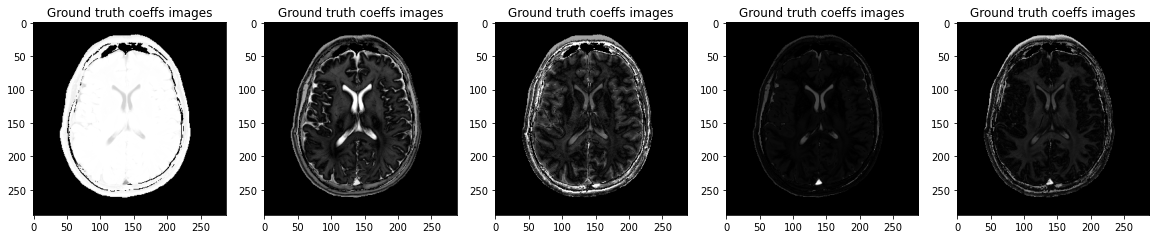

In [13]:
# trials for generating the true ground truth coefficient images
K=5#first 5 basis vectors

Phi = basis3[:,:K]
X_proj_coeffs = np.dot(Phi.T, X_sim3).T#take the projection coefficients along the first 5 basis vectors
print(X_proj_coeffs.shape)
GT_coeff_img = np.zeros([288,288,5])

for index in range(K):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, K, index+1)
    Im_synthetic = np.zeros([288,288])
    Im_synthetic[np.nonzero(mask)] = X_proj_coeffs[:,index]
    GT_coeff_img[:,:,index] = Im_synthetic#*porton_image_data[:,:,slice_index]
    plt.imshow(np.abs(Im_synthetic),cmap=plt.get_cmap('gray'))#, vmin=0, vmax=0.000001) 
    plt.title('Ground truth coeffs images')

#GT_coeff_img = GT_coeff_img/np.amax(np.abs(GT_coeff_img))

Shape of simulated signal evolution:  (48, 35818)


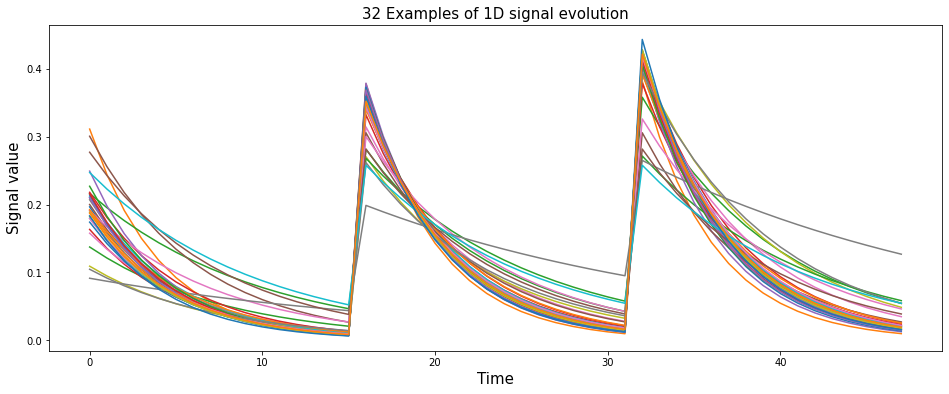

In [15]:
N_plot = 32#number of signal evolutions to be plotted
ridx = np.random.permutation(X_sim3.shape[1])#randomly select 32 signal evolutions
print('Shape of simulated signal evolution: ',X_sim3.shape)
#X_reshape = np.reshape(X_sim, [N_TRs, ETL, T1T2_vals])
#plot any random 32 single evolutions
plt.figure(figsize=(16,6))
plt.plot(X_sim3[:,ridx[:N_plot]]);
plt.title('32 Examples of 1D signal evolution',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Signal value',fontsize=15)
plt.show()

In [16]:
#spin echo signal evolution definition
def spin_echo(T1T2_vals, TE, TR):
    return np.exp(-TE / T1T2_vals[1,:]) * (1 - np.exp(-(TR-TE)/T1T2_vals[0,:]))

#inverse recovery spin echo used for generating T1 and T2 FLAIR images
def IR_spin_echo(T1T2_vals, TE, TR, TI):
    return (1 - 2 * np.exp(-(TI)/T1T2_vals[0,:]) + np.exp(-TR/T1T2_vals[0,:]))*np.exp(-TE / T1T2_vals[1,:]) 

error (min mean max): 0.03334396701870858 0.037654231728223714 0.045762949702162


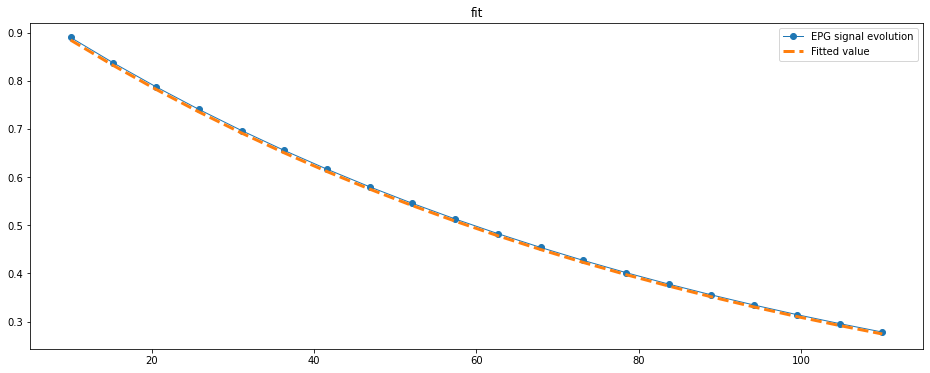

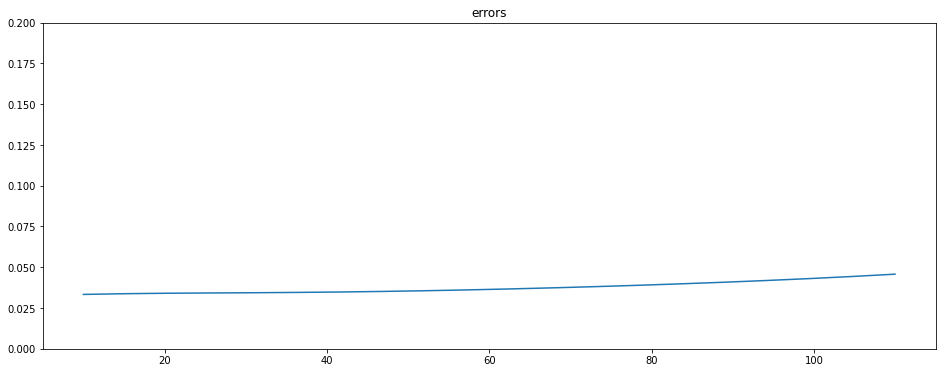

In [37]:
#Generating the linear coefficients for the spin echo contrasts
# for T2 image, TR = 5000, TE = 100
X = X_sim3#simulated signal evolutions

TE_vals = np.linspace(10, 110, num=20)#pick 20 values of TE
TR = 8000#fix TR value

Xhat_se = np.zeros((X.shape[1], len(TE_vals)))#this will be populated by doing linear combination prediction

Y_se = np.zeros(Xhat_se.shape)#this is the curve that we get from sequence EPG outputs
errs = np.zeros((len(TE_vals),))

Q_se = np.zeros((K, len(TE_vals)))#paper have as c, to store the linear combination coefficients

for i, TE in enumerate(TE_vals):
    Y_se[:,i] = spin_echo(T1T2_vals, TE, TR)#find actual spin evolution through spin-echo function defined earlier

    A = np.dot(Phi.T, X).T#find the projection coefficinets, shape would be (37000,5) as 37000 T1T2 vals and 5 basis

    #the linear equation is as follows:- A*q = Y_se
    q, qresid, qrank, qs = np.linalg.lstsq(A, Y_se[:,i],rcond=None)#least squares fitting to find the linear combination 
    #coefficients, Ax = b, this takes as input both A and b & returns x solution
    #q shape would be (5,), as we have taken 5 basis points
    
    Q_se[:,i] = q

    errs[i] = nrmse(Y_se[:, i], np.dot(A, q))#the error between actual signal evolution Y_se and the one find out through
    #linar combination

    Xhat_se[:,i] = np.dot(A, q)#the linear combined evaluated signal evolution, shape 37000,20 as there are 20 TE vals
    
    
plt.figure(figsize=(16,6))
plt.plot(TE_vals, Y_se[ridx[:1],:].T, 'o-', linewidth=1,label = 'EPG signal evolution');
#plt.gca().set_color_cycle(None)

plt.plot(TE_vals, Xhat_se[ridx[:1], :].T, '--', linewidth=3,label='Fitted value')
plt.legend()
plt.title('fit')

plt.figure(figsize=(16,6))
plt.plot(TE_vals, errs)
plt.ylim([0, .2])
plt.title('errors')

print('error (min mean max):', np.min(errs), np.mean(errs), np.max(errs))

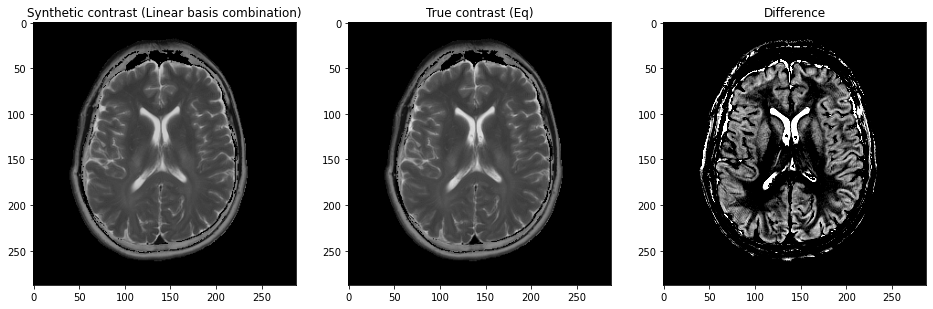

T2 contrast images


In [38]:
plt.figure(figsize=(16,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = Xhat_se[:,-1]
Im_synthetic1 = Im_synthetic1
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,3,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_se[:,-1]
Im_synthetic = Im_synthetic
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('True contrast (Eq)')

plt.subplot(1,3,3)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_se[:,-1]
Im_synthetic = Im_synthetic
plt.imshow(Im_synthetic - Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=1*0.01)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('Difference')

plt.show()

print('T2 contrast images')

In [39]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.04581094457318891


In [40]:
True_contrast_T2_image = Im_synthetic;#image from the spin echo equation
LC_T2_image = Im_synthetic1;#linear combination image

In [41]:
c_linear_coeffs_T2 = Q_se[:,19];#linear combination coefficients for T2 image
np.save('subject2/96ETL_c_linear_coeffs_T2.npy',c_linear_coeffs_T2)
print(Q_se[:,19])

[-0.33716445  0.84533115 -0.08311551  0.50087718  0.14648703]


error (min mean max): 0.017385679913294594 0.06074116655859172 0.1335122859757535


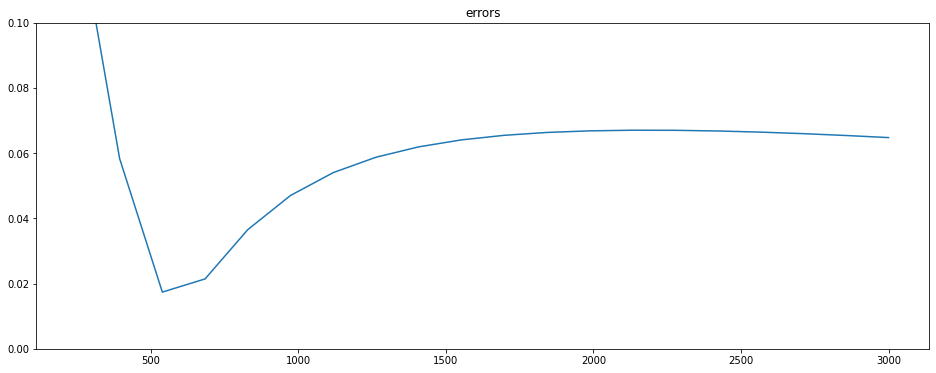

In [42]:
#generating linear coefficients for the case of spin echo contrasts
#simulating for different TR values
# for T1 image, TR = 400, TE = 10
TR_vals = np.linspace(250, 3000, num=20)
TE = 10

Xhat_se = np.zeros((X.shape[1], len(TR_vals)))
Xhat_se_NN = np.zeros((X.shape[1], len(TR_vals)))

Y_se = np.zeros(Xhat_se.shape)
errs = np.zeros((len(TR_vals),))

Q_sr = np.zeros((K, len(TR_vals)))

for i, TR in enumerate(TR_vals):
    tic = time.time()
    Y_se[:,i] = spin_echo(T1T2_vals, TE, TR)
    toc = time.time()
    
    A = np.dot(Phi.T, X).T
#     sc = np.linalg.norm(A, axis=1)
#     A = A / sc[:,None]

    
    tic = time.time()
    q, qresid, qrank, qs = np.linalg.lstsq(A, Y_se[:,i],rcond=None)
    toc = time.time()
    
    Q_sr[:,i] = q

    errs[i] = nrmse(Y_se[:, i], np.dot(A, q))

    Xhat_se[:,i] = np.dot(A, q)


plt.figure(figsize=(16,6))
plt.plot(TR_vals, errs)
plt.ylim([0, .1])
plt.title('errors')

print('error (min mean max):', np.min(errs), np.mean(errs), np.max(errs))

#fp = '/home/jtamir/t2shuffling-data/2017-06-15_mineddyseqviews_varflip_varTR/15Jun17_Ex5099_Ser15/Ex5099_Ser15/'
#cfl.writecfl('%s/Q_sr' % fp, Q_sr.reshape((1, 1, 1, 1, 1, 1, K, -1)))
#print(np.abs(Q_sr.T))

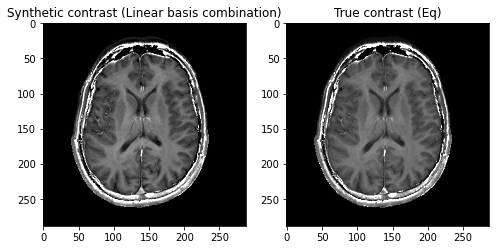

T1 contrast images


In [43]:
plt.figure(figsize=(8,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = Xhat_se[:,0]
Im_synthetic1 = Im_synthetic1#*PD_subject1
plt.subplot(1,2,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,2,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_se[:,0]
Im_synthetic = Im_synthetic#*PD_subject1
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('True contrast (Eq)')
plt.show()

print('T1 contrast images')

In [44]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.13471839850433126


In [45]:
True_contrast_T1_image = Im_synthetic;
LC_T1_image = Im_synthetic1;#linear combination image

In [46]:
c_linear_coeffs_T1 = Q_sr[:,0];#linear combination coefficients for T2 image
np.save('subject2/96ETL_c_linear_coeffs_T1.npy',c_linear_coeffs_T1)
print(Q_sr[:,0])

[-0.21368538  0.0512541  -1.53805002  0.37366932 -1.33917002]


In [47]:
#simulating linear coefficients for the case of inversion spin recovery pulse sequences
#for T1 FLAIR => TI = 2200, TR = 400, TE =10
#for T2 FLAIR => TI = 2200, TR = 8000, TE = 100


#this is for T1 FLAIR from now on
TI_vals = np.linspace(800, 4000, num=20)
TE = 10
TR = 2100

Xhat_se = np.zeros((X.shape[1], len(TI_vals)))
Xhat_se_NN = np.zeros((X.shape[1], len(TI_vals)))
Y_se = np.zeros(Xhat_se.shape)
errs = np.zeros((len(TI_vals),))

Q_ir = np.zeros((K, len(TI_vals)))

for i, TI in enumerate(TI_vals):
    tic = time.time()
    Y_se[:,i] = IR_spin_echo(T1T2_vals, TE, TR, TI)
    toc = time.time()
    
    A = np.dot(Phi.T, X).T
#     sc = np.linalg.norm(A, axis=1)
#     A = A / sc[:,None]

    
    tic = time.time()
    q, qresid, qrank, qs = np.linalg.lstsq(A, Y_se[:,i],rcond=None)
    toc = time.time()

    Q_ir[:,i] = q
    
    errs[i] = nrmse(Y_se[:, i], np.dot(A, q))

    Xhat_se[:,i] = np.dot(A, q)


print('error (min mean max):', np.min(errs), np.mean(errs), np.max(errs))

#fp = '/home/jtamir/t2shuffling-data/2017-06-15_mineddyseqviews_varflip_varTR/15Jun17_Ex5099_Ser15/Ex5099_Ser15/'
#cfl.writecfl('%s/Q_ir' % fp, Q_ir.reshape((1, 1, 1, 1, 1, 1, K, -1)))

#print(np.abs(Q_ir.T))

error (min mean max): 0.04737542738440192 0.06274837267228925 0.07211276336169427


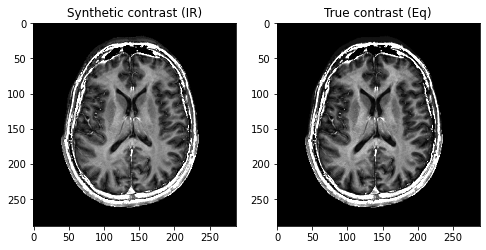

T1 FLAIR images


In [48]:
plt.figure(figsize=(8,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = Xhat_se[:,0]
Im_synthetic1 = Im_synthetic1#*PD_subject1
plt.subplot(1,2,1)
plt.imshow(np.abs(Im_synthetic1),cmap=plt.get_cmap('gray'), vmin=0,vmax = 0.5)#, vmax=.05*np.max(np.abs(Im_synthetic))) 
plt.title('Synthetic contrast (IR)')

plt.subplot(1,2,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_se[:,0]
Im_synthetic = Im_synthetic#*PD_subject1
plt.imshow(np.abs(Im_synthetic),cmap=plt.get_cmap('gray'), vmin=0,vmax = 0.5)#, vmax=.05*np.max(np.abs(Im_synthetic))) 
plt.title('True contrast (Eq)')
plt.show()

print('T1 FLAIR images')

In [49]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.07230100006108678


In [50]:
True_contrast_T1_FLAIR = Im_synthetic;#image from the spin echo equation
LC_T1_FLAIR = Im_synthetic1;#linear combination image

In [51]:
c_linear_coeffs_T1FLAIR = Q_ir[:,0];#linear combination coefficients for T2 image
np.save('subject2/96ETL_c_linear_coeffs_T1FLAIR.npy',c_linear_coeffs_T1FLAIR)
print(Q_ir[:,0])

[-2.28913704e-01 -1.78632845e-03 -2.47629798e+00  4.45363684e-01
 -1.44909501e+00]


In [86]:
#simulating linear coefficients for the case of inversion spin recovery pulse sequences
#for T1 FLAIR => TI = 2200, TR = 400, TE =10
#for T2 FLAIR => TI = 2200, TR = 8000, TE = 100

TI_vals = np.linspace(1600, 4000, num=20)
TE = 110
TR = 8000

Xhat_se = np.zeros((X.shape[1], len(TI_vals)))
Xhat_se_NN = np.zeros((X.shape[1], len(TI_vals)))
Y_se = np.zeros(Xhat_se.shape)
errs = np.zeros((len(TI_vals),))

Q_ir = np.zeros((K, len(TI_vals)))

for i, TI in enumerate(TI_vals):
    tic = time.time()
    Y_se[:,i] = IR_spin_echo(T1T2_vals, TE, TR, TI)
    toc = time.time()
    
    A = np.dot(Phi.T, X).T
#     sc = np.linalg.norm(A, axis=1)
#     A = A / sc[:,None]

    
    tic = time.time()
    q, qresid, qrank, qs = np.linalg.lstsq(A, Y_se[:,i],rcond=None)
    toc = time.time()

    Q_ir[:,i] = q
    
    errs[i] = nrmse(Y_se[:, i], np.dot(A, q))

    Xhat_se[:,i] = np.dot(A, q)

print('error (min mean max):', np.min(errs), np.mean(errs), np.max(errs))

#fp = '/home/jtamir/t2shuffling-data/2017-06-15_mineddyseqviews_varflip_varTR/15Jun17_Ex5099_Ser15/Ex5099_Ser15/'
#cfl.writecfl('%s/Q_ir' % fp, Q_ir.reshape((1, 1, 1, 1, 1, 1, K, -1)))

#print(np.abs(Q_ir.T))

error (min mean max): 0.12628570431806654 0.17557478804608526 0.23883751842609535


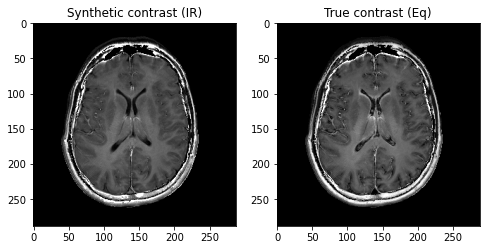

T2 FLAIR contrast images


In [90]:
plt.figure(figsize=(8,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = Xhat_se[:,0]
Im_synthetic1 = Im_synthetic1#*PD_subject1
plt.subplot(1,2,1)
plt.imshow(np.abs(Im_synthetic1),cmap=plt.get_cmap('gray'), vmin=0,vmax = .5)#, vmax=.05*np.max(np.abs(Im_synthetic))) 
plt.title('Synthetic contrast (IR)')

plt.subplot(1,2,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_se[:,0]
Im_synthetic = Im_synthetic#*PD_subject1
plt.imshow(np.abs(Im_synthetic),cmap=plt.get_cmap('gray'), vmin=0,vmax = 0.5)#, vmax=.05*np.max(np.abs(Im_synthetic))) 
plt.title('True contrast (Eq)')
plt.show()

print('T2 FLAIR contrast images')

In [91]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.2459555849834875


In [92]:
True_contrast_T2_FLAIR = Im_synthetic;#image from the spin echo equation
LC_T2_FLAIR = Im_synthetic1;#linear combination image

In [93]:
c_linear_coeffs_T2FLAIR = Q_ir[:,0];#linear combination coefficients for T2 image
np.save('subject2/96ETL_c_linear_coeffs_T2FLAIR.npy',c_linear_coeffs_T2FLAIR)
print(Q_ir[:,0])

[-0.17409258  0.16477372 -1.19906501 -0.48309544 -0.94552801]


In [1]:
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(True_contrast_T1_image), cmap='gray',vmax = 0.5,vmin=0)
plt.title('T1 weighted image')

plt.subplot(1,4,2)
plt.imshow(np.abs(True_contrast_T2_image), cmap='gray',vmax = 1,vmin=0)
plt.title('T2 weighted image')

plt.subplot(1,4,3)
plt.imshow(np.abs(True_contrast_T1_FLAIR), cmap='gray',vmax = 1,vmin=0)
plt.title('T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(True_contrast_T2_FLAIR), cmap='gray',vmax = 0.5,vmin=0)
plt.title('T2 FLAIR image')

plt.show()

print('         True contrast images using estimated T1,T2 values and without PD for subject 2')

NameError: name 'plt' is not defined

In [96]:
PD_map = np.load('subject2/Subject2_PD.npy')

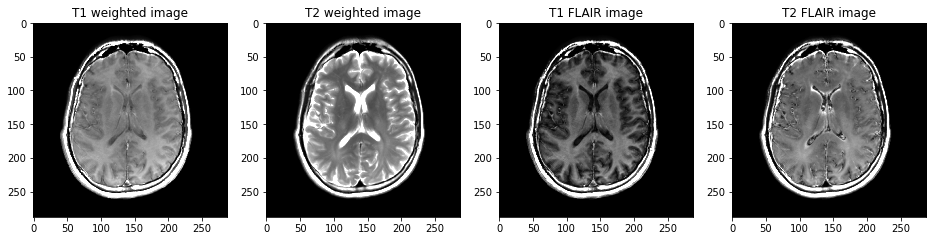

         True contrast images using estimated T1,T2 values and with PD for subject 2


In [97]:
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(PD_map*True_contrast_T1_image[:,:]), cmap='gray',vmax = 0.0003,vmin=0)
plt.title('T1 weighted image')

plt.subplot(1,4,2)
plt.imshow(np.abs(PD_map*True_contrast_T2_image[:,:]), cmap='gray',vmax = 0.0005,vmin=0)
plt.title('T2 weighted image')

plt.subplot(1,4,3)
plt.imshow(np.abs(PD_map*True_contrast_T1_FLAIR[:,:]), cmap='gray',vmax = 0.0005,vmin=0)
plt.title('T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(PD_map*True_contrast_T2_FLAIR[:,:]), cmap='gray',vmax = 0.0003,vmin=0)
plt.title('T2 FLAIR image')

plt.show()

print('         True contrast images using estimated T1,T2 values and with PD for subject 2')

In [100]:
#saving the different contrast images
np.save('subject2/48ETL_semc_True_contrast_T1_FLAIR.npy',True_contrast_T1_FLAIR*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T2_FLAIR.npy',True_contrast_T2_FLAIR*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T1_image.npy',True_contrast_T1_image*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T2_image.npy',True_contrast_T2_image*PD_map)